# Initial setup

In [30]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = "arn:aws:iam::941656036254:role/service-role/AmazonSageMaker-ExecutionRole-20210904T193230"

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sm-modelparallel-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-east-1-941656036254


In [31]:
data_url = "s3://sagemaker-us-east-1-941656036254/hymenoptera_data"

In [ ]:
bucket

## Train Script



In [139]:
! pygmentize 2_sources/train_resnet_sm.py

# Example: https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/entry_point/pt_res50_cifar10_distributed.py

from __future__ import division, print_function
import argparse
import os
import logging
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import time
from torch.optim import lr_scheduler
from smdebug import modes

# from smdebug.pytorch import get_hook
import smdebug.pytorch as smd


logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

NUM_CLASSES = 2  # two classes: ants and bees


def model_step(model, data, target, criterion):
    outputs = model(data)
    loss = criterion(outputs, target)
    return outputs, loss


def train_model(
    model, device, dataloaders, criterion, optimizer, scheduler, args, hook
):

    for epoch in range(1, args.num_epochs + 1):
        for phase in ["train", "val"]:
            if phase == "train":
              

# Debugging

In [185]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

actions = rule_configs.ActionList(
    rule_configs.StopTraining())


collection_configs=[
        CollectionConfig(
            name="weights",
            parameters={
                "save_histogram": "True"
                }
            ),
        CollectionConfig(name="losses"),
        #CollectionConfig(name="relu_input", parameters={"end_step": '0'}),
        #CollectionConfig(
        #    name="gradients",
        #    parameters={
        #        "save_histogram": "True"
        #        }
        #    ),
    ]

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient(), actions=actions),
    Rule.sagemaker(rule_configs.overfit(), actions=actions),
    Rule.sagemaker(rule_configs.overtraining(), actions=actions),
    Rule.sagemaker(rule_configs.poor_weight_initialization(), actions=actions),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "1"},
    collection_configs=collection_configs
)

In [186]:
for collection_config in hook_config.collection_configs:
    print(collection_config)
    print(collection_config.name)
    print(collection_config.parameters)

weights
{'save_histogram': 'True'}
losses
None


# Remote Mode

In [201]:

from sagemaker.pytorch import PyTorch

instance_type = 'ml.p2.xlarge'
instance_count = 1
job_name = "pytorch-sm-debugging"
tb_debug_path = f"s3://{bucket}/tensorboard/{job_name}"

tensorboard_output_config = TensorBoardOutputConfig(
    s3_output_path=tb_debug_path
)


debug_estimator = PyTorch(
          entry_point="train_resnet_sm.py", # Pick your train script
          source_dir='2_sources',
          role=role,
          instance_type=instance_type,
          sagemaker_session=sagemaker_session,
          image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.10.2-gpu-py38-cu113-ubuntu20.04-sagemaker",
          instance_count=instance_count,
          hyperparameters={
              "batch-size":64,
              "num-epochs":5,
              "input-size" : 224,
              "num-data-workers" : 4,
              "feature-extract":False,
          },
          disable_profiler=True,
          rules=rules,
          debugger_hook_config=hook_config,
          tensorboard_output_config=tensorboard_output_config,
          base_job_name=job_name,
      )

In [202]:
debug_estimator.fit(inputs={"train":f"{data_url}/train", "val":f"{data_url}/val"}, wait=False)

In [204]:
tensors_path = debug_estimator.latest_job_debugger_artifacts_path()

import smdebug.pytorch as smd
from smdebug import trials
trial = smd.create_trial(tensors_path)

print(f"Saved these tensors: {trial.tensor_names()}")
print(f"Loss values during evaluation were {trial.tensor('CrossEntropyLoss_output_0').values()}")
#print(f"{trial.tensor('relu_input_0').values()}")
# example of plotting values of tensors:
#https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-debugger/model_specific_realtime_analysis/autoencoder_mnist/autoencoder_mnist.html


[2022-06-12 02:00:43.996 C02Y82MBJGH5:2535 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-941656036254/pytorch-sm-debugging-2022-06-12-05-32-51-033/debug-output
Saved these tensors: ['CrossEntropyLoss_output_0', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.weight', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.conv1.weight', 'ResNet_layer1.1.conv2.weight', 'ResNet_layer2.0.bn1.weight', 'ResNet_layer2.0.bn2.weight', 'ResNet_layer2.0.conv1.weight', 'ResNet_layer2.0.conv2.weight', 'ResNet_layer2.0.downsample.0.weight', 'ResNet_layer2.0.downsample.1.weight', 'ResNet_layer2.1.bn1.weight', 'ResNet_layer2.1.bn2.weight', 'ResNet_layer2.1.conv1.weight', 'ResNet_layer2.1.conv2.weight', 'ResNet_layer3.0.bn1.weight', 'ResNet_layer3.0.bn2.weight', 'ResNet_layer3.0.conv1.weight', 'ResNet_layer3.0.conv2.w

## Visualize tensors

In [205]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug import modes

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=modes.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=modes.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


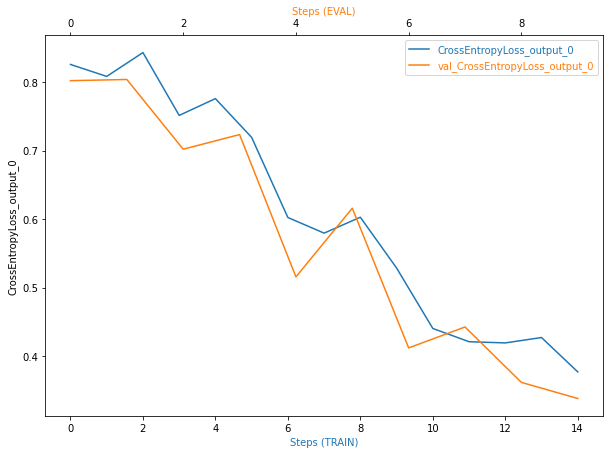

In [206]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Rules summary

In [208]:
for  summary in debug_estimator.latest_training_job.rule_job_summary():
    print(f"Rule: {summary['RuleConfigurationName']}, status: {summary['RuleEvaluationStatus']}")

Rule: VanishingGradient, status: NoIssuesFound
Rule: Overfit, status: NoIssuesFound
Rule: Overtraining, status: NoIssuesFound
Rule: PoorWeightInitialization, status: NoIssuesFound


In [209]:
## Checking TensorBoard

! tensorboard --logdir  {tb_debug_path}

TensorFlow installation not found - running with reduced feature set.
W0612 02:01:23.775732 4709645824 profile_plugin_loader.py:71] Unable to load profiler plugin. Import error: No module named 'wrapt'
I0612 02:01:25.044523 123145401819136 plugin.py:429] Monitor runs begin
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6007/ (Press CTRL+C to quit)
^C


## Profiling Application

In [176]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    rule_configs,
    ProfilerRule
)

actions = rule_configs.ActionList(
    rule_configs.StopTraining())


#collection_configs=[
#        CollectionConfig(
#            name="weights",
#            parameters={
#                "save_histogram": "True"
#                }
#            ),
#        CollectionConfig(name="losses"),
#    ]

rules = [
    #Rule.sagemaker(rule_configs.vanishing_gradient(), actions=actions),
    #Rule.sagemaker(rule_configs.overfit(), actions=actions),
    #Rule.sagemaker(rule_configs.overtraining(), actions=actions),
    #Rule.sagemaker(rule_configs.poor_weight_initialization(), actions=actions),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()) # TODO: need to review different profiler rules https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html#profiler-report
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "1", "eval.save_interval": "1"},
    #collection_configs=collection_configs
)

In [177]:
import time
from sagemaker.debugger import (ProfilerConfig, 
                                FrameworkProfile, 
                                DetailedProfilingConfig, 
                                DataloaderProfilingConfig, 
                                PythonProfilingConfig,
                                PythonProfiler, cProfileTimer)

profiler_config=ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(
        detailed_profiling_config=DetailedProfilingConfig(
            start_step=2, 
            num_steps=1
        ),
        dataloader_profiling_config=DataloaderProfilingConfig(
            start_step=2, 
            num_steps=1
        ),
        python_profiling_config=PythonProfilingConfig(
            start_step=2, 
            num_steps=1, 
            python_profiler=PythonProfiler.CPROFILE, 
            cprofile_timer=cProfileTimer.TOTAL_TIME
        )
    )
)


In [179]:

from sagemaker.pytorch import PyTorch

instance_type = 'ml.p2.xlarge'
instance_count = 1
job_name = "pytorch-sm-profiling-1"
bucket = sagemaker_session.default_bucket()
#tb_debug_path = f"s3://{bucket}/tensorboard/{job_name}"

##tensorboard_output_config = TensorBoardOutputConfig(
##    s3_output_path=tb_debug_path
##)

profiler_estimator = PyTorch(
          entry_point="train_resnet_sm.py", # Pick your train script
          source_dir='2_sources',
          role=role,
          instance_type=instance_type,
          sagemaker_session=sagemaker_session,
          image_uri="763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker",
          instance_count=instance_count,
          hyperparameters={
              "batch-size":64,
              "num-epochs":5,
              "input-size" : 224,
              "num-data-workers" : 8,
              "feature-extract":False,
          },
          disable_profiler=False,
          profiler_config=profiler_config,
          rules=rules,
        #  debugger_hook_config=hook_config,
        #  tensorboard_output_config=tensorboard_output_config,
          base_job_name=job_name,
      )

In [180]:
profiler_estimator.fit(inputs={"train":f"{data_url}/train", "val":f"{data_url}/val"}, wait=False)

In [189]:
for  summary in profiler_estimator.latest_training_job.rule_job_summary():
    print(summary)

{'RuleConfigurationName': 'ProfilerReport', 'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:941656036254:processing-job/pytorch-sm-profiling-1-202-profilerreport-584d1c95', 'RuleEvaluationStatus': 'NoIssuesFound', 'LastModifiedTime': datetime.datetime(2022, 6, 12, 1, 24, 28, 777000, tzinfo=tzlocal())}


# Profiling

In [190]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = profiler_estimator.latest_training_job.job_name
region = "us-east-1"
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-941656036254/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 2, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 2, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 2, "NumSteps": 1, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760'}}
s3 path:s3://sagemaker-us-east-1-941656036254/pytorch-sm-profiling-1-2022-06-12-05-14-59-451/profiler-output


Profiler data from system is available


Also here there are details on how to do it: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-access-data-profiling-default-plot.html


In [191]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-06-12 01:25:56.660 C02Y82MBJGH5:2535 INFO metrics_reader_base.py:134] Getting 9 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [192]:
framework_metrics_reader = tj.get_framework_metrics_reader()

In [193]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

metrics_histogram = MetricsHistogram(system_metrics_reader)
metrics_histogram.plot(
    starttime=0, 
    endtime=system_metrics_reader.get_timestamp_of_latest_available_file(), 
    select_dimensions=["CPU", "GPU", "I/O"], # optional
    select_events=["total"]                  # optional
)

Found 15149 system metrics events from timestamp_in_us:0 to timestamp_in_us:1655011440000000
select events:['total']
select dimensions:['CPU', 'GPU', 'I/O']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'I/OWaitPercentage-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [194]:
#rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = f"s3://{bucket}/{training_job_name}/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-941656036254/pytorch-sm-profiling-1-2022-06-12-05-14-59-451/rule-output
